In [1]:
###################
#IMPORT
###################

from os import listdir
from os.path import isfile, join
import io
import csv

# pdfminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams

from nltk.tokenize import TextTilingTokenizer
from matplotlib import pylab
from pylab import *
import matplotlib.pyplot as plt

import re
import pandas as pd 

%matplotlib inline
import seaborn as sns; sns.set_theme()

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
####################
####################
#### PARAMETERS ####
####################
####################

###################
#Define a standard size for the next figures
###################
plt.rcParams["figure.figsize"] = (30,20)


##################
# Define the folder path
##################
PATH_INPUT_FOLDER="/Users/morganm/Documents/IATA/New_way/textTiling/test_all_documents_with_page_nb/01_input_folder/agm-new/"
PATH_TEXT_FOLDER="/Users/morganm/Documents/IATA/New_way/textTiling/test_all_documents_with_page_nb/02_text_folder/agm-historic-test/"
PATH_OUTPUT_SECTIONS_FOLDER="/Users/morganm/Documents/IATA/New_way/textTiling/test_all_documents_with_page_nb/03_output_sections_folder/"
OUTPUT_SECTION_FILENAME ='output_sections_agm-historic_v2.csv'

##################
# Define the algorithm parameters
##################
in_w=58
in_k=5

In [4]:
################################
# Function to parse pdf document
################################
def pdfminer(input_file, input_folder):
    # Parameters to associate the pdf page number to the text
    separate_symbols="####"
    # input option
    password = ''
    pagenos = set()
    maxpages = 0
    # output option
    layoutmode = 'normal'
    codec = 'utf-8'
    caching = True
    laparams = LAParams()
    outfile = PATH_TEXT_FOLDER+input_file+".txt"
    rsrcmgr = PDFResourceManager(caching=caching)
    inc_page = 1

    outfp = io.open(outfile, 'wt', encoding=codec, errors='ignore')
    fp = io.open(input_folder+input_file, 'rb')
    
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,
                  caching=caching, check_extractable=True):
        retstr = io.StringIO()
        device = TextConverter(rsrcmgr, retstr,laparams=laparams,codec=codec)
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        interpreter.process_page(page)
        output_text = retstr.getvalue()
        page_text = separate_symbols+str(inc_page)+separate_symbols+output_text
        #print(page_text)
        outfp.write(page_text)
        inc_page = inc_page+1
        retstr.close()

    fp.close()
    device.close()
    outfp.close()

In [7]:
################################
# STEP 1 : Convert PDF document to text document
################################
print("STEP 1 : Convert PDF document to text document")
start_time = time.time()

i=0
print("Path folder for the original documents : ")
print(PATH_INPUT_FOLDER)
files = [f for f in listdir(PATH_INPUT_FOLDER) if (isfile(join(PATH_INPUT_FOLDER, f))) and (f != ".DS_Store")]
print("Nb of Meeting Minutes in PDF format :", len(files))

print("...Process is working...")
for file in files:
    # Convert PDF to text file
    print("#### Doc : ",i,"#####")
    print(file)
    pdfminer(file, PATH_INPUT_FOLDER)
    print("############")
    i = i+1
print("************************************************************")
print("[OK] The Job is done. The documents are converted to text format in : ", PATH_TEXT_FOLDER)

# Screen Execution time
print("Execution time : %s seconds ---" % (time.time() - start_time))
print("************************************************************")

STEP 1 : Convert PDF document to text document
Path folder for the original documents : 
/Users/morganm/Documents/IATA/New_way/textTiling/test_all_documents_with_page_nb/01_input_folder/agm-new/
Nb of Meeting Minutes in PDF format : 15
...Process is working...
#### Doc :  0 #####
AGM_2017_73th_CANCUN_english.pdf
############
#### Doc :  1 #####
AGM_2010_66th_draft_without_attachment.pdf
############
#### Doc :  2 #####
AGM_2004_60th_TBD_english.pdf
############
#### Doc :  3 #####
AGM_2011_67th_draft_without_attachment.pdf
############
#### Doc :  4 #####
AGM_2006_62th_TBD.pdf
############
#### Doc :  5 #####
AGM_2015_71th_draft_without_attachment.pdf
############
#### Doc :  6 #####
AGM_2014_70th_draft_without_attachment.pdf
############
#### Doc :  7 #####
AGM_2003_59th_TBD_english.pdf
############
#### Doc :  8 #####
AGM_2007_63th_TBD.pdf
############
#### Doc :  9 #####
AGM_2016_72th_DUBLIN_english.pdf
############
#### Doc :  10 #####
AGM_2013_69th_draft_without_attachment.pdf
###

In [6]:
############################
# Create list of word tokens
# > Removing the special caracters
# > Lemmatization
#############################
regex = re.compile(r'[\n\r\t]')
def create_token_list(text):
    text = regex.sub("", text)
    #  "nlp" Object is used to create documents with linguistic annotations.
    my_doc = nlp(text)
    token_list = []
    for token in my_doc:
        token_list.append(token.lemma_)
    return token_list

####################################
# Create list of word tokens after : 
#  > removing stopwords
#  > removing punctuation 
#  > Converting lower case
####################################
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

def remove_stopwords(token_list):
    filtered_sentence =dict() 
    for word in token_list:
        lexeme = nlp.vocab[word]
        if (lexeme.is_stop == False) and (lexeme.is_punct == False):
            if word.lower() in filtered_sentence:
                filtered_sentence[word.lower()] += 1
            else:
                filtered_sentence[word.lower()] = 1
    return filtered_sentence

In [10]:
##################################
# STEP 2 : TextTiling algorithm
# Launch  simulation with defined w and k parameters
##################################
print("##################################")
print("STEP 2 : TextTiling algorithm")
print("##################################")
start_time = time.time()


df = pd.DataFrame(columns = ['document', 'nb_sections', "ind_coverage"])

# Launch the simulation
print("> Path folder for the text documents : ", PATH_TEXT_FOLDER)
files = [f for f in listdir(PATH_TEXT_FOLDER) if isfile(join(PATH_TEXT_FOLDER, f))]
print("> Nb of Meeting Minutes in TEXT format :", len(files))
# STEP 2 : TextTiling
#print("*************************************")
print("> Initialitaion of TextTiling algorithm : w= "+str(in_w)+" and k= "+str(in_k))
#print("*************************************")

with open(PATH_OUTPUT_SECTIONS_FOLDER+OUTPUT_SECTION_FILENAME, mode='w') as csvfile:
    writer_csv = csv.writer(csvfile, delimiter=',')
    writer_csv.writerow(["section_title", "section_content", "file_name", "section_number", "pages", "year"])
    for file in files:
        # Ignore the OS config file
        if file != ".DS_Store":
            data_save = []      
            data_save.append(file)
            print("****** FILE : ", file, " ******")
            ttt = TextTilingTokenizer(w=in_w, k=in_k)
            print("[OK] Initialization TextTiling")
            file_tmp = open(PATH_TEXT_FOLDER+file, encoding="utf-8", errors='ignore')
            text_blob = file_tmp.read()
            file_tmp.close()
            print("[OK] Download of the text document")
            print("[IN PROGRESS] Launch the TextTiling algorithm")
            tokens = ttt.tokenize(text_blob)
            print("[OK] TextTiling algorithm")
            print("> Number of sections : "+str(len(tokens)))
            data_save.append(len(tokens))

            coverage_words_before= []

            for i in range(len(tokens)):
                #print("\n\n")
                #print("************************")
                #print("Section n"+str(i))
                #print("************************")
                word_list = create_token_list(tokens[i])
                word_list_filtered = remove_stopwords(word_list)

                if i>0:
                    word_list_before = create_token_list(tokens[i-1])
                    word_list_before_filtered = remove_stopwords(word_list_before)

                #print("==== BEGIN DIFFERENCE WORD (section "+str(i)+")====")
                list_diff_words_with_before_sentence = []

                for key in word_list_filtered.keys(): 
                    if i>0:
                        if not key in word_list_before_filtered: 
                            list_diff_words_with_before_sentence.append(key)            

                #print("List of different words with the previous section : "+str(len(list_diff_words_with_before_sentence)))
                if i>0:
                    list_diff_words_with_before_sentence.sort()
                    coverage_before = round(len(list_diff_words_with_before_sentence)/len(word_list_filtered)*100)
                    coverage_words_before.append(coverage_before)
                    #print("Difference with the previous section : ", str(coverage_before)+"%")
                    #print(list_diff_words_with_before_sentence) 
                else:
                    #print(">Premiere word list, il n 'y a pas de comparaison avec la précédente")
                    coverage_words_before.append(100)

                #print("==== END DIFFERENCE WORD ====")

                paragraph = tokens[i].replace("\n", " ")
                output_sectionname = file + "-sec"+str(i+1)
                output_sectionname=output_sectionname.replace(".pdf.txt","")
                filename = file.replace(".txt","")
                #output_filename = PATH_OUTPUT_SECTIONS_FOLDER + file + "-sec" + str(i) + ".txt"
                #output_file = open(output_filename, "a")
                #output_file.write(paragraph)
                #output_file.close()
                #########
                #csv_file
                ######### 
                #doc_title,doc_content,file_name,file_url?,section number,pages,year
                # Sear Year
                regex_year = r'[12][0-9]{3}'
                if re.search(regex_year, file):
                    year = re.findall(regex_year, file)[0]
                else:
                    year = "1900"
                
                #Search page number
                regex_page_number = r'####\d{1,4}####'
                if re.search(regex_page_number, paragraph):
                    list_page_number = re.findall(regex_page_number, paragraph)
                    # If the beginning of the section is the page beginning
                    if paragraph.startswith('####') == True:
                        first_page = re.sub("####","",list_page_number[0])
                    # Else, the beginning of the beginning is in the previous page 
                    else:
                        first_page = str(int(re.sub("####","",list_page_number[0]))-1)
                    
                    # If the end of the section is the page end
                    if paragraph.endswith('####') == True:
                        last_page = str(int(re.sub("####","",list_page_number[-1]))-1)
                    # Else, the end of the section is in the next page 
                    else:
                        last_page = re.sub("####","",list_page_number[-1])
                
                # We are again in the same page (as the previous section)
                else:
                    first_page =last_page
                    last_page=last_page
                
                if first_page == last_page:
                        pages = first_page
                else:
                    pages = first_page+"-"+last_page
                writer_csv.writerow([output_sectionname, paragraph, filename, i+1, pages, year])

                #print("==== TEXT SECTION (section "+str(i)+") ====")
                #print(paragraph)

            print("> Average difference : "+ str(round(mean(coverage_words_before),2))+"%")
            data_save.append(round(mean(coverage_words_before),2))
            df.loc[len(df)] = data_save
            print("> Execution time for this document : %s seconds ---" % (time.time() - start_time))

print("************************************************************")
print("[OK] The Job is done. The sections are located in : ", PATH_OUTPUT_SECTIONS_FOLDER)
print("Job details :")
print(df)

# Screen Execution time
print("Execution time : %s seconds ---" % (time.time() - start_time))
print("************************************************************")

##################################
STEP 2 : TextTiling algorithm
##################################
> Path folder for the text documents :  /Users/morganm/Documents/IATA/New_way/textTiling/test_all_documents_with_page_nb/02_text_folder/agm-historic-test/
> Nb of Meeting Minutes in TEXT format : 15
> Initialitaion of TextTiling algorithm : w= 58 and k= 5
****** FILE :  AGM_2010_66th_draft_without_attachment.pdf.txt  ******
[OK] Initialization TextTiling
[OK] Download of the text document
[IN PROGRESS] Launch the TextTiling algorithm
[OK] TextTiling algorithm
> Number of sections : 19
> Average difference : 78.11%
> Execution time for this document : 1.5553529262542725 seconds ---
****** FILE :  AGM_2009_65th_TBD.pdf.txt  ******
[OK] Initialization TextTiling
[OK] Download of the text document
[IN PROGRESS] Launch the TextTiling algorithm
[OK] TextTiling algorithm
> Number of sections : 20
> Average difference : 78.5%
> Execution time for this document : 2.920552968978882 seconds ---
***

Nombre de sections : 
31
Moyenne des pourcentages de différence : 
76.74
Ecart type des différences entre chaque section : 
10.79
Série des différences (en %) entre chaque section : 
[100, 85, 73, 82, 70, 86, 81, 81, 73, 83, 73, 88, 81, 69, 80, 73, 66, 73, 68, 61, 82, 37, 74, 91, 68, 79, 81, 84, 73, 83, 81]


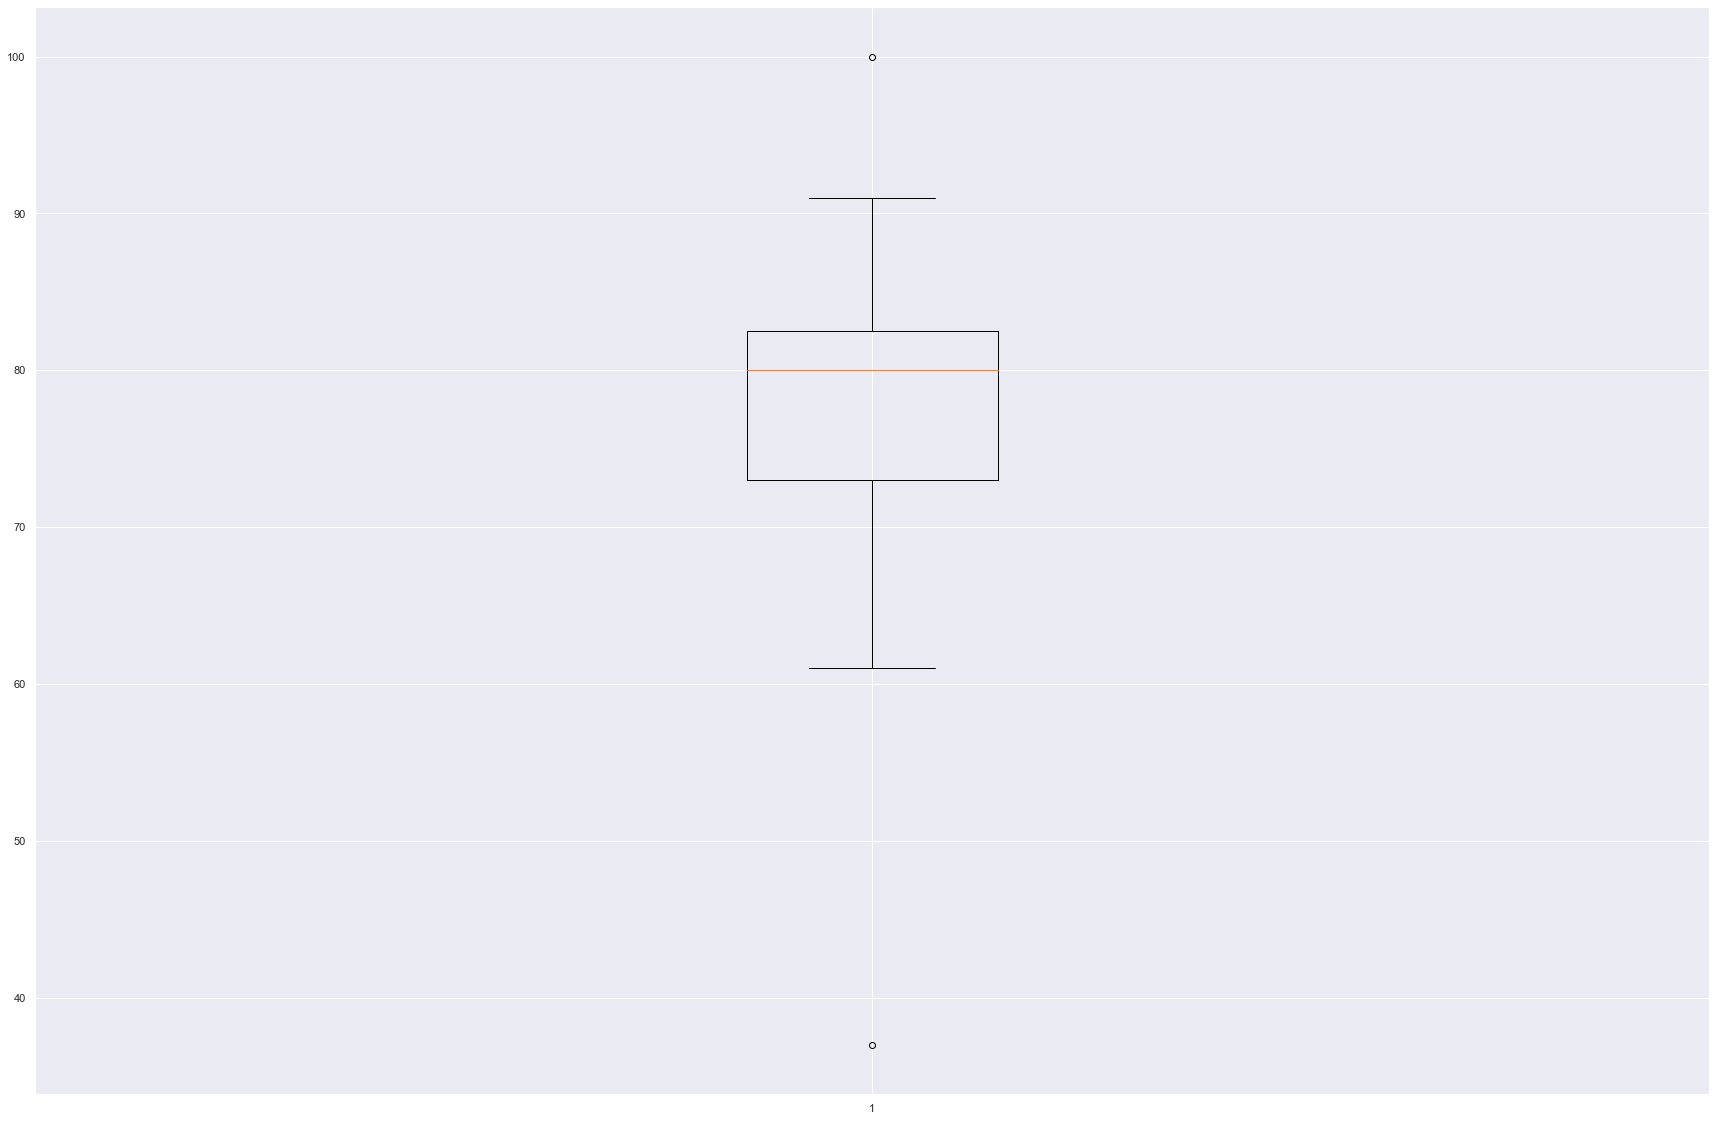

In [9]:
#####################
# STATISTIQUES SUPPLEMENTAIRES SUR LA SIMULATION SPECIFIQUE
#####################
print("Nombre de sections : ") 
print(len(coverage_words_before))
print("Moyenne des pourcentages de différence : ") 
print(round(mean(coverage_words_before),2))
print("Ecart type des différences entre chaque section : ") 
print(round(np.std(coverage_words_before),2))
print("Série des différences (en %) entre chaque section : ") 
print(coverage_words_before)

# Creating plot 
plt.boxplot(coverage_words_before) 
# Two subplots, unpack the axes array immediately
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)
# show plot 
plt.show() 

In [6]:
#################
# LAUNCH ONE SIMULATION WITH DEFINED W AND K PARAMETERS
# The goal is to have lot of information about a specific simulation
#################

# Parameters ###
in_specific_w=58
in__specific_k=5
################
#print("*************************************")
print("****** TEXT TILING with w= "+str(in_specific_w)+" and k= "+str(in__specific_k))
#print("*************************************")
i=0
ttt = TextTilingTokenizer(w=in_specific_w, k=in__specific_k, demo_mode=True)
#text_blob = download_file()
file_tmp = open(PATH_TEXT_FOLDER+"AGM_1999_55th ANNUAL GENERAL MEETING 30 May - 1 June 1999 Rio de Janeiro DOCUMENTATION Vol II ENGLISH.pdf.txt", encoding="utf-8", errors='ignore')
text_blob = file_tmp.read()
file_tmp.close()
s, ss, d, b = ttt.tokenize(text_blob)
print("Nombre de segment boundaries :" + str(b.count(1)))
print("Nombre de -gap_scores : "+str(len(s)))

print("Inc Segment boudaries - Depth scores - smooth scores - gap scores ")
while i < len(b):
    print(str(i)+" - "+str(b[i])+ " - "+str(d[i])+ " - "+str(ss[i])+" - "+str(s[i]))
    i +=1
                                    
print("gap_scores : ") 
print(s)
print("----------------")
print(" smooth_scores : ") 
print(ss) 
print("----------------")
print(" depth_scores: ") 
print(d) 
print("----------------")
print("segment_boundaries: ")
print(b)


****** TEXT TILING with w= 58 and k= 5
Nombre de segment boundaries :296
Nombre de -gap_scores : 1713
Inc Segment boudaries - Depth scores - smooth scores - gap scores 
0 - 0 - 0 - 0.07192370411543123 - 0.04348853820356281
1 - 0 - 0 - 0.07792405592424427 - 0.13779456365238762
2 - 0 - 0 - 0.08449718338236896 - 0.05248906591678239
3 - 0 - 0 - 0.09613774680634601 - 0.0632079205779369
4 - 0 - 0 - 0.1272849171088314 - 0.17271625392431877
5 - 0 - 0.0 - 0.16200121049743926 - 0.14593057682423857
6 - 0 - 0.025841743839264242 - 0.15331741179308017 - 0.16735680074376041
7 - 0 - 0.011675470030415025 - 0.1587998868975703 - 0.14666485781124156
8 - 0 - 0.01141333330028077 - 0.15906202362770455 - 0.162378002137709
9 - 0 - 0.006548347365483875 - 0.16392700956250145 - 0.16814321093416318
10 - 0 - 0.0 - 0.17047535692798532 - 0.16125981561563224
11 - 1 - 0.06537770807332094 - 0.14969002788884203 - 0.18202304423416063
12 - 0 - 0.03057248354782549 - 0.16370992337519422 - 0.10578722381673326
13 - 0 - 0.02973

In [ ]:
#####################
# STATISTIQUES SUPPLEMENTAIRES SUR LA SIMULATION SPECIFIQUE
#####################
pylab.xlabel("Sentence Gap index")
pylab.ylabel("Gap Scores")
pylab.plot(range(len(s)), s, label="Gap Scores")
pylab.plot(range(len(ss)), ss, label="Smoothed Gap scores")
pylab.plot(range(len(d)), d, label="Depth scores")
pylab.stem(range(len(b)), b)
pylab.legend()
pylab.show() 